## Design TI Calculation function

Use the turbine-power based approach to make a rough calculation of TI.  This removes TI as a free variable
and hopefully makes tuning easier with one less non-uniqueness problem.  Based on methods explained in 

Based on Duc, T., Coupiac, O., Girard, N., Giebel, G., & Göçmen, T. (2018). Local turbulence parameterization improves the Jensen wake model and its implementation for power optimization of an operating wind farm. Wind Energy Science Discussions, (October), 1–23. https://doi.org/10.5194/wes-2018-62

# Note that this method unfortunately breaks down at rated

In [1]:
import matplotlib.pyplot as plt
import floris.tools as wfct
import numpy as np
import pandas as pd
import copy
import seaborn as sns
import pickle
from scipy.interpolate import interp1d

## Use FLORIS to build a crude wind speed estimator from power

In [2]:
fi_g = wfct.floris_interface.FlorisInterface("../example_input.json")
turbine = fi_g.floris.farm.turbines[0]

<


In [3]:
ws = np.array(turbine.power_thrust_table['wind_speed'])

In [4]:
cp = np.array(turbine.power_thrust_table['power'])

In [23]:
ct = np.array(turbine.power_thrust_table['thrust'])

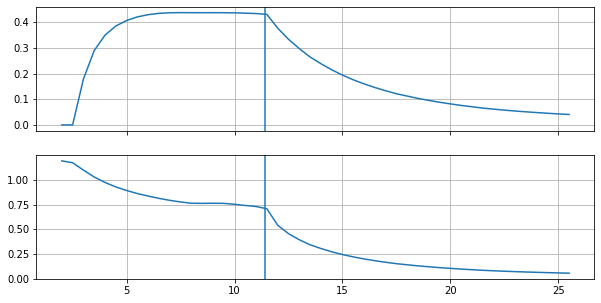

In [34]:
# Quickly check the curves
fig, axarr = plt.subplots(2,1,sharex=True,figsize=(10,5))
ax = axarr[0]
ax.plot(ws,cp)
ax.grid()
ax.axvline(11.4) # According to the NREL 5MW ref doc this is rated, checks out
ax = axarr[1]
ax.plot(ws,ct)
ax.grid()
ax.axvline(11.4)

In [5]:
fCpInterp = interp1d(ws, cp, fill_value='extrapolate')

In [6]:
air_density = 1.225
rotor_radius = 126/2.
area = np.pi * rotor_radius**2

def power_function(ws):
    return 0.5 * air_density * area * fCpInterp(ws) * ws**3

In [7]:
power = power_function(ws)

In [8]:
ws

array([ 2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ,  6.5,  7. ,
        7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5, 11. , 11.5, 12. , 12.5,
       13. , 13.5, 14. , 14.5, 15. , 15.5, 16. , 16.5, 17. , 17.5, 18. ,
       18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5, 22. , 22.5, 23. , 23.5,
       24. , 24.5, 25. , 25.5])

In [9]:
ws_limit = ws[ws<12.0]
pow_limit = power[ws<12.0]

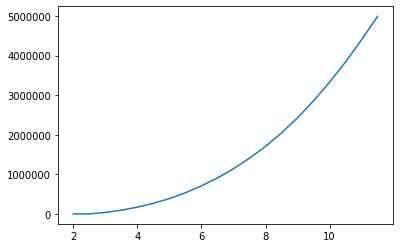

In [10]:
plt.plot(ws_limit,pow_limit)

In [11]:
pow_limit

array([      0.        ,       0.        ,   36722.17646948,
         94656.64690022,  170596.22563973,  267749.19577529,
        387646.60349914,  533961.58810258,  707405.81137472,
        909996.03294889, 1142718.91539299, 1407498.38742067,
       1707127.10702895, 2047333.37624772, 2430578.92269176,
       2858309.94849889, 3329101.31470679, 3842973.47246078,
       4403856.83160906, 4994945.14843245])

In [12]:
ws_limit

array([ 2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ,  6.5,  7. ,
        7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5, 11. , 11.5])

In [13]:
ws_estimator = interp1d(pow_limit, ws_limit, fill_value='extrapolate')

In [14]:
# Grab a data set
si = wfct.sowfa_utilities.SowfaInterface('../../examples/sowfa_example')

../../examples/sowfa_example
No preprocess file found


In [15]:
si.turbine_output.head()

,time,turbine,pitch,azimuth,nacYaw,torqueRotor,rotSpeedFiltered,powerRotor,powerGenerator,torqueGen,thrust,rotSpeed
751,300.4,0,0,326.885307,260.0,2.037096e+06,9.518198,2.029039e+06,1.988452e+06,21801.802283,375332.320166,9.511530
752,300.8,0,0,349.696050,260.0,2.029194e+06,9.511574,2.019670e+06,1.984212e+06,21771.464702,374734.452147,9.504476
753,301.2,0,0,12.488782,260.0,2.021031e+06,9.504523,2.009957e+06,1.979707e+06,21739.197108,374110.942739,9.496972
754,301.6,0,0,35.262408,260.0,2.012651e+06,9.497021,1.999945e+06,1.974927e+06,21704.895702,373444.963211,9.489011
755,302.0,0,0,58.015829,260.0,2.004154e+06,9.489064,1.989735e+06,1.969869e+06,21668.537031,372730.797031,9.480592


In [22]:
si.turbine_output.turbine.uniqueue()

array([0])

In [16]:
powers = si.get_time_power_t(0)

In [17]:
ws_est = ws_estimator(powers)

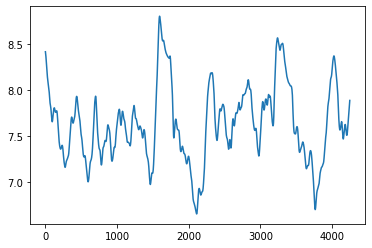

In [18]:
plt.plot(ws_est)

In [19]:
np.mean(ws_est)

7.624691007465836

In [20]:
np.std(ws_est)

0.4166054016894502

In [21]:
100. * np.std(ws_est) / np.mean(ws_est)

5.463898816116279

Based on Duc, T., Coupiac, O., Girard, N., Giebel, G., & Göçmen, T. (2018). Local turbulence parameterization improves the Jensen wake model and its implementation for power optimization of an operating wind farm. Wind Energy Science Discussions, (October), 1–23. https://doi.org/10.5194/wes-2018-62

(See Fig 4)

Might expect TI calculated to be half what would be measured by nacelle anemonoter so could call effective TI twice this

## Proposed estimation function

In [67]:
def ti_calc_nrel_5mw(pow_W):
    ws_est = ws_estimator(pow_W)
    return 2 * 100. * np.std(ws_est) / np.mean(ws_est)

In [68]:
ti_calc_nrel_5mw(powers)

10.927797632232558